# Predict survival on the Titanic

# Dataset is from https://www.kaggle.com/competitions/titanic

Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
train = pd.read_csv('train.csv') #import the dataset

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<AxesSubplot:>

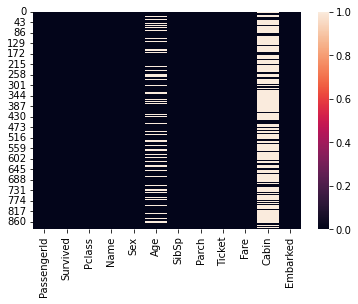

In [7]:
sns.heatmap(data=train.isnull()) #checking is there any missing data

In [8]:
#as most of the data in 'cabin' is missing, we dropped that column
train = train.drop('Cabin', axis=1)

In [9]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [10]:
#making the item 'Sex' and 'Embarked' become binary items for later regression modeling
gender = pd.get_dummies(data=train['Sex'], drop_first=True)
embarked = pd.get_dummies(data=train['Embarked'], drop_first=True)

In [11]:
print(embarked, gender)

     Q  S
0    0  1
1    0  0
2    0  1
3    0  1
4    0  1
..  .. ..
886  0  1
887  0  1
888  0  1
889  0  0
890  1  0

[891 rows x 2 columns]      male
0       1
1       0
2       0
3       0
4       1
..    ...
886     1
887     0
888     0
889     1
890     1

[891 rows x 1 columns]


In [12]:
#as there are some missing data in age, we can try to fill them in according to their Pclass

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

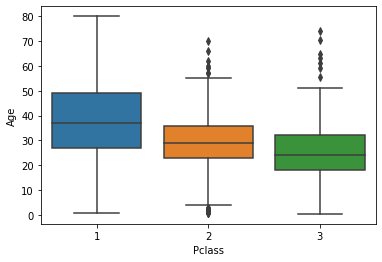

In [13]:
sns.boxplot(data=train, x='Pclass', y='Age')

In [14]:
def change_age(cols):
    Pclass = cols[0]
    Age = cols[1]
    
    if pd.isnull(Age):
    
        if Pclass== 1:
            return  38
        elif Pclass== 2:
            return 30
        elif Pclass== 3:
            return 25
    else:
        return Age


In [15]:
train['Age'] = train[['Pclass','Age']].apply(change_age, axis=1)

In [16]:
#the missing age are filled in with the mean age of the Pclass they belong to
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


In [17]:
#group up all the item into the dataset
train = pd.concat([train,gender,embarked],axis=1)

In [18]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,1,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25.0,1,2,W./C. 6607,23.4500,S,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,1,0,0


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)>

In [21]:
X = train.drop(['Name','Sex','Ticket','Survived','Embarked'], axis=1)
y = train['Survived']

In [22]:
X

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000,1,0,1
887,888,1,19.0,0,0,30.0000,0,0,1
888,889,3,25.0,1,2,23.4500,0,0,1
889,890,1,26.0,0,0,30.0000,1,0,0


In [23]:
#split the data into train set and test seet 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
logmodel = LogisticRegression()

In [26]:
#train the machine learning model with logistic regression
logmodel.fit(X_train,y_train)

/Users/kamyinli/.conda/envs/mypy39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
#test the machine learning model
predictions = logmodel.predict(X_test)

In [28]:
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [30]:
#check the accuracy of the model
#the recall value are 0.88 and 0.61, 
#the precision value are 0.76 and 0.8. if the model predict a person did not survive, 76% that the person really did not survive
#the F1 score closer to 1 means better accuracy. We got 0.77 overall and have 77% accuracy. 
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       154
           1       0.80      0.61      0.69       114

    accuracy                           0.77       268
   macro avg       0.78      0.75      0.75       268
weighted avg       0.77      0.77      0.76       268



array([[136,  18],
       [ 44,  70]])

In [31]:
logmodel.coef_

array([[ 3.91767024e-04, -7.28756323e-01, -2.92808167e-02,
        -3.76006303e-01, -9.88888261e-02,  9.89039439e-03,
        -2.58953256e+00,  1.18893594e-02,  3.86788125e-01]])

# Importing a new set of data to predict the survival rate

In [32]:
df1 = pd.read_csv('test.csv')

In [33]:
df1 = df1.drop('Cabin', axis=1)
gender = pd.get_dummies(data=df1['Sex'], drop_first=True)
embarked = pd.get_dummies(data=df1['Embarked'], drop_first=True)
df1['Age'] = df1[['Pclass','Age']].apply(change_age, axis=1)
df1 = pd.concat([df1,gender,embarked],axis=1)
df2= df1.drop(['Name','Sex','Ticket','Embarked'], axis=1)







In [34]:
df2.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1
2,894,2,62.0,0,0,9.6875,1,1,0
3,895,3,27.0,0,0,8.6625,1,0,1
4,896,3,22.0,1,1,12.2875,0,0,1


<AxesSubplot:>

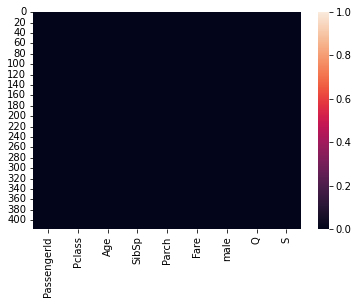

In [35]:
sns.heatmap(data=df2.isnull())

In [36]:
df3=df2.dropna(axis=0)

In [37]:
logmodel.predict(df3)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [38]:
result = pd.DataFrame(data=logmodel.predict(df3), index=df3.index, columns=['Result'])

In [39]:
result

,Result
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0
